In [53]:
import networkx as nx
import numpy as np
from spenet import slq_spenet, ste_spenet, exact_spenet
from utils import load_graph, rodger_graphs, weighted_graphs, unweighted_graphs, relative_error
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
step = 10
nv = 100
avg = 10

# 各グラフについて k=3,4 のとき

In [55]:
# k の値を変えて実験する
k = 4

In [56]:
def add_relative_error(df, G, now_id, name):
    gtypes = ["normalized_laplacian", "laplacian", "adjacency"]
    for gtype in gtypes:
        if gtype == "normalized_laplacian":
            M = nx.normalized_laplacian_matrix(G)
        elif gtype == "laplacian":
            M = nx.laplacian_matrix(G)
        elif gtype == "adjacency":
            M = nx.adjacency_matrix(G)
        
        errors = []
        exact = exact_spenet(M, k, method="prod")
        for seed in range(avg):
            #ste = ste_spenet(M, k, nv=nv, seed=seed)
            slq = slq_spenet(M, k, step=step, nv=nv, seed=seed)
            errors.append(relative_error(slq, exact))
        errors = np.array(errors)    
        df = df.append({"id":now_id,"name":name, "k":k, "matrix":gtype,"exact":exact, "relative_error":errors.mean()},ignore_index=True)
    return df

df = pd.DataFrame(columns=["id", "name", "k",  "matrix", "exact", "relative_error"])
graph_df = pd.DataFrame(columns=["id", "name","n","m","is_weighted"])

now_id = 0
# unweighted_graphs
is_weighted = False
for path in unweighted_graphs:
    G = load_graph(path, is_weighted)
    
    name = os.path.splitext(os.path.basename(path))[0]
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, name:{name},  path:{path}, n:{n}, m:{m}")
    graph_df = graph_df.append({"id":now_id, "name":name, "n":n, "m":m, "is_weighted":is_weighted},ignore_index=True)
    df = add_relative_error(df, G, now_id, name)
    now_id += 1


# weighted_graphs
is_weighted = True
for path in weighted_graphs:
    G = load_graph(path, is_weighted)
    
    name = os.path.splitext(os.path.basename(path))[0]
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, name:{name},  path:{path}, n:{n}, m:{m}")
    graph_df = graph_df.append({"id":now_id, "name":name, "n":n, "m":m, "is_weighted":is_weighted},ignore_index=True)
    df = add_relative_error(df, G, now_id, name)
    now_id += 1




now_id:0, name:bio-celegans,  path:data/networkrepository/bio/bio-celegans/bio-celegans.mtx, n:453, m:2025
now_id:1, name:bio-celegans-dir,  path:data/networkrepository/bio/bio-celegans-dir/bio-celegans-dir.edges, n:453, m:2040
now_id:2, name:bio-diseasome,  path:data/networkrepository/bio/bio-diseasome/bio-diseasome.mtx, n:516, m:1188
now_id:3, name:ENZYMES_g295,  path:data/networkrepository/cheminformatics/ENZYMES_g295/ENZYMES_g295.edges, n:123, m:139
now_id:4, name:ENZYMES_g296,  path:data/networkrepository/cheminformatics/ENZYMES_g296/ENZYMES_g296.edges, n:125, m:141
now_id:5, name:ENZYMES_g297,  path:data/networkrepository/cheminformatics/ENZYMES_g297/ENZYMES_g297.edges, n:121, m:149
now_id:6, name:ia-crime-moreno,  path:data/networkrepository/interaction/ia-crime-moreno/ia-crime-moreno.edges, n:829, m:1475
now_id:7, name:ia-email-univ,  path:data/networkrepository/interaction/ia-email-univ/ia-email-univ.mtx, n:1133, m:5451
now_id:8, name:ia-enron-only,  path:data/networkrepositor

In [57]:
df.head()

,id,name,k,matrix,exact,relative_error
0,0,bio-celegans,4,normalized_laplacian,7.304754e+02,0.003762
1,0,bio-celegans,4,laplacian,3.902614e+09,0.091421
2,0,bio-celegans,4,adjacency,7.230540e+05,0.101652
3,1,bio-celegans-dir,4,normalized_laplacian,7.121180e+02,0.004895
4,1,bio-celegans-dir,4,laplacian,3.902614e+09,0.125919


In [58]:
df[df["relative_error"]>1]

,id,name,k,matrix,exact,relative_error


In [59]:
graph_df.head()

,id,name,n,m,is_weighted
0,0,bio-celegans,453,2025,False
1,1,bio-celegans-dir,453,2040,False
2,2,bio-diseasome,516,1188,False
3,3,ENZYMES_g295,123,139,False
4,4,ENZYMES_g296,125,141,False


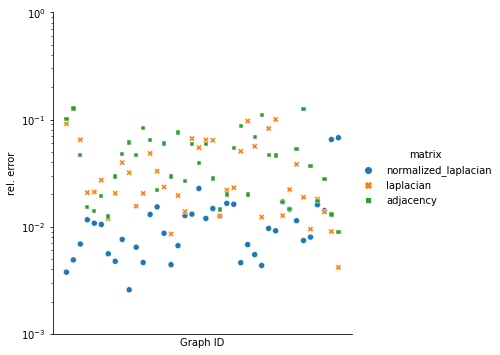

In [60]:
tmp_df = df[df["k"]==k]
ax = sns.relplot(
    data=tmp_df,
    x="id", y="relative_error",
    hue="matrix", style="matrix"
)
ax.set(xlabel="Graph ID",ylabel="rel. error", yscale="log", ylim=[1e-3, 1], xticks=[]) #
plt.savefig(f'plot/plot_each_graph_k{k}.png')
plt.show()

In [50]:
# latex 用に出力する

for index in range(now_id):
    name = graph_df[graph_df["id"]==index]["name"].values[0]
    gtypes = [ "adjacency", "laplacian", "normalized_laplacian"]
    print_row = name.replace("_", "\_")
    for gtype in gtypes:
        exact = df.query("id==@index and matrix==@gtype")["exact"].values[0]
        relative_error = df.query("id==@index and matrix==@gtype")["relative_error"].values[0]
        print_row += f" & {exact:.3e} & {relative_error:.5f}"
    print_row += "\\\\"
    print(print_row)


bio-celegans & 1.970e+04 & 0.12352 & 2.106e+07 & 0.06977 & 5.931e+02 & 0.00302\\
bio-celegans-dir & 2.130e+04 & 0.15158 & 2.106e+07 & 0.09613 & 5.825e+02 & 0.00403\\
bio-diseasome & 8.160e+03 & 0.03805 & 4.305e+05 & 0.04023 & 8.243e+02 & 0.00559\\
ENZYMES\_g295 & 1.200e+01 & 0.51855 & 4.238e+03 & 0.01685 & 2.880e+02 & 0.00933\\
ENZYMES\_g296 & 1.200e+01 & 0.83381 & 4.050e+03 & 0.01630 & 2.931e+02 & 0.01071\\
ENZYMES\_g297 & 5.400e+01 & 0.21166 & 5.458e+03 & 0.02121 & 2.710e+02 & 0.00949\\
ia-crime-moreno & 1.640e+02 & 0.73894 & 2.284e+05 & 0.00732 & 1.431e+03 & 0.00475\\
ia-email-univ & 3.206e+04 & 0.03573 & 6.076e+06 & 0.01340 & 1.496e+03 & 0.00352\\
ia-enron-only & 5.334e+03 & 0.05443 & 3.260e+05 & 0.02250 & 1.929e+02 & 0.00604\\
ia-fb-messages & 1.495e+04 & 0.26510 & 1.793e+07 & 0.02107 & 1.644e+03 & 0.00211\\
ia-infect-dublin & 4.268e+04 & 0.04542 & 2.653e+06 & 0.01041 & 5.074e+02 & 0.00514\\
ia-infect-hyper & 1.012e+05 & 0.08505 & 1.201e+07 & 0.01640 & 1.204e+02 & 0.00355\\
adjnou

In [40]:
# latex 用にグラフごとの詳細を出力

for index in range(now_id):
    name = graph_df[graph_df["id"]==index]["name"].values[0]
    n = graph_df[graph_df["id"]==index]["n"].values[0]
    m = graph_df[graph_df["id"]==index]["m"].values[0]
    avg_deg = 2*m/n
    density = m/(n*(n-1))
    is_weighted  = graph_df[graph_df["id"]==index]["is_weighted"].values[0]
    print_row = name.replace("_", "\_")
    print_row += f" & {n}"
    print_row += f" & {m}"
    print_row += f" & {avg_deg:.2f}"
    print_row += f" & {density:.2e}"
    print_row += " & weighted" if is_weighted else " & unweighted"
    print_row += "\\\\"
    print(print_row)



bio-celegans & 453 & 2025 & 8.94 & 9.89e-03 & unweighted\\
bio-celegans-dir & 453 & 2040 & 9.01 & 9.96e-03 & unweighted\\
bio-diseasome & 516 & 1188 & 4.60 & 4.47e-03 & unweighted\\
ENZYMES\_g295 & 123 & 139 & 2.26 & 9.26e-03 & unweighted\\
ENZYMES\_g296 & 125 & 141 & 2.26 & 9.10e-03 & unweighted\\
ENZYMES\_g297 & 121 & 149 & 2.46 & 1.03e-02 & unweighted\\
ia-crime-moreno & 829 & 1475 & 3.56 & 2.15e-03 & unweighted\\
ia-email-univ & 1133 & 5451 & 9.62 & 4.25e-03 & unweighted\\
ia-enron-only & 143 & 623 & 8.71 & 3.07e-02 & unweighted\\
ia-fb-messages & 1266 & 6451 & 10.19 & 4.03e-03 & unweighted\\
ia-infect-dublin & 410 & 2765 & 13.49 & 1.65e-02 & unweighted\\
ia-infect-hyper & 113 & 2196 & 38.87 & 1.74e-01 & unweighted\\
adjnoun & 112 & 425 & 7.59 & 3.42e-02 & unweighted\\
bcspwr03 & 118 & 297 & 5.03 & 2.15e-02 & unweighted\\
bibd\_9\_5 & 126 & 1217 & 19.32 & 7.73e-02 & unweighted\\
can\_144 & 144 & 720 & 10.00 & 3.50e-02 & unweighted\\
polbooks & 105 & 441 & 8.40 & 4.04e-02 & unweight

# k=4.5 のとき

In [13]:
k=4.5

In [26]:
def add_relative_error(df, G, now_id):
    gtypes = ["normalized_laplacian", "laplacian"]
    for gtype in gtypes:
        if gtype == "normalized_laplacian":
            M = nx.normalized_laplacian_matrix(G)
        elif gtype == "laplacian":
            M = nx.laplacian_matrix(G)
        elif gtype == "adjacency":
            M = nx.adjacency_matrix(G)
        
        errors = []
        exact = exact_spenet(M, k, method="eig")
        for seed in range(avg):
            #ste = ste_spenet(M, k, nv=nv, seed=seed)
            slq = slq_spenet(M, k, step=step, nv=nv, seed=seed)
            errors.append(relative_error(slq, exact))
        errors = np.array(errors)    
        df = df.append({"id":now_id, "relative_error":errors.mean(), "k":k, "matrix":gtype},ignore_index=True)
    return df

df = pd.DataFrame(columns=["id", "relative_error", "k", "matrix"])

now_id = 0
# unweighted_graphs
is_weighted = False
for path in unweighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1

"""
# rodger_graphs
is_weighted = False
for path in rodger_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1
"""

# weighted_graphs
is_weighted = True
for path in weighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1


now_id:0, path:data/networkrepository/bio/bio-celegans/bio-celegans.mtx, n:453, m:2025
now_id:1, path:data/networkrepository/bio/bio-celegans-dir/bio-celegans-dir.edges, n:453, m:2040
now_id:2, path:data/networkrepository/bio/bio-diseasome/bio-diseasome.mtx, n:516, m:1188
now_id:3, path:data/networkrepository/cheminformatics/ENZYMES_g295/ENZYMES_g295.edges, n:123, m:139
now_id:4, path:data/networkrepository/cheminformatics/ENZYMES_g296/ENZYMES_g296.edges, n:125, m:141
now_id:5, path:data/networkrepository/cheminformatics/ENZYMES_g297/ENZYMES_g297.edges, n:121, m:149
now_id:6, path:data/networkrepository/interaction/ia-crime-moreno/ia-crime-moreno.edges, n:829, m:1475
now_id:7, path:data/networkrepository/interaction/ia-email-univ/ia-email-univ.mtx, n:1133, m:5451
now_id:8, path:data/networkrepository/interaction/ia-enron-only/ia-enron-only.mtx, n:143, m:623
now_id:9, path:data/networkrepository/interaction/ia-fb-messages/ia-fb-messages.mtx, n:1266, m:6451
now_id:10, path:data/networkre

/Users/murakaminaoki/git/research/SPENet/spenet.py:52: RuntimeWarning: invalid value encountered in power
  return lambda x: np.power(x, k)


now_id:21, path:data/networkrepository/miscellaneous/GD98_b/GD98_b.mtx, n:121, m:132
now_id:22, path:data/networkrepository/miscellaneous/GD98_c/GD98_c.mtx, n:112, m:168
now_id:23, path:data/networkrepository/miscellaneous/GD99_c/GD99_c.mtx, n:105, m:120
now_id:24, path:data/networkrepository/miscellaneous/gent113/gent113.mtx, n:113, m:639
now_id:25, path:data/networkrepository/bio/bio-CE-GT/bio-CE-GT.edges, n:924, m:3239
now_id:26, path:data/networkrepository/bio/bio-CE-LC/bio-CE-LC.edges, n:1387, m:1648
now_id:27, path:data/networkrepository/bio/bio-DM-LC/bio-DM-LC.edges, n:658, m:1129
now_id:28, path:data/networkrepository/bio/bio-SC-TS/bio-SC-TS.edges, n:636, m:3959
now_id:29, path:data/networkrepository/miscellaneous/eco-florida/eco-florida.edges, n:128, m:2075
now_id:30, path:data/networkrepository/miscellaneous/eco-foodweb-baydry/eco-foodweb-baydry.edges, n:128, m:2106
now_id:31, path:data/networkrepository/miscellaneous/gre_115/gre_115.mtx, n:115, m:382
now_id:32, path:data/net

In [24]:
df[df["id"]==20]

,id,relative_error,k,matrix
40,20,0.071211,4.5,laplacian
41,20,0.013687,4.5,normalized_laplacian


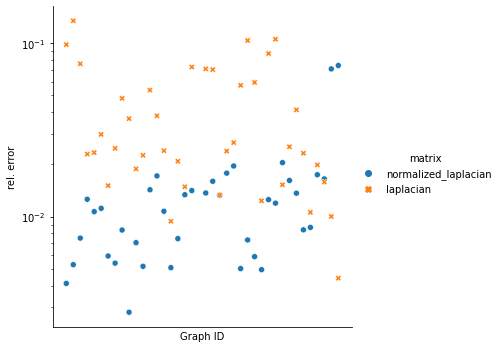

In [27]:
k = 4.5
tmp_df = df[df["k"]==k]
ax = sns.relplot(
    data=tmp_df,
    x="id", y="relative_error",
    hue="matrix", style="matrix"
)
ax.set(xlabel="Graph ID",ylabel="rel. error", yscale="log", xticks=[]) #
plt.savefig(f'plot/plot_each_graph_k{k}.png')
plt.show()